In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 14.7 MB/s 
     |████████████████████████████████| 81 kB 12.8 MB/s 
     |████████████████████████████████| 209 kB 105.2 MB/s 
     |████████████████████████████████| 78 kB 7.0 MB/s 
     |████████████████████████████████| 112 kB 84.6 MB/s 
     |████████████████████████████████| 146 kB 81.7 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=cca1ec3cffe9f93239fee036b28b8c4cd626de1ed359e4df26b91fe2f4d18d15
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

import joblib
import pickle
import optuna

warnings.filterwarnings('ignore')
%matplotlib inline

from datetime import datetime

datetime.today()
today = datetime.today()
str_today = today.strftime('%y%m%d')
save_model = str_today + '_lstm_saved_model.pth'
save_model

'220619_lstm_saved_model.pth'

### 함수정의

In [ ]:
def sliding_windows(data, lookback_length, forecast_length):

    x = []
    y = []
    
    for i in range(lookback_length, len(data) - forecast_length + 1):
        _x = data[(i-lookback_length) : i]
        _y = data[i : (i + forecast_length)]
        x.append(_x)
        y.append(_y)
    return np.array(x), np.array(y)


def get_data_loader(X, y, batch_size):

    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    train_ds = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
    train_dl = DataLoader(train_ds, batch_size = batch_size)

    val_ds = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
    val_dl = DataLoader(val_ds, batch_size = batch_size)

    input_size = x_train.shape[-1]

    return train_dl, val_dl, input_size

### Data loading && Preproces

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/실무인증/Data/crypto_currency_data_key_v2.pickle', 'rb') as f:
    data = pickle.load(f)


data = data[['date', 'trade_price']]
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.sort_values(by='date').reset_index(drop=True)

scaler = MinMaxScaler()
scale_cols = ['trade_price']

# Loockback_period & forecasting_period
max_prediction_length = 20
lookback_length = 90
forecast_length = 1
training_data_max = len(data) - max_prediction_length


# 학습용 데이터
data_p = data.iloc[:training_data_max, :]
training_data = scaler.fit_transform(data_p[scale_cols])



### Metric 생성을 위한 oot sample 정의

In [ ]:
# max_prediction_length 만큼의 데이터는 예측 데이터와 비교를 위해 분리
# actual_data = data.loc[~data.index.isin(data_p.index)][scale_cols]
# actual_data.shape
# Training set에 없는 데이터로 구성
# Input과 output의 pair로 정의
x_for_metric = scaler.fit_transform(data[training_data_max -lookback_length : training_data_max][scale_cols])
y_for_metric = scaler.fit_transform(data[training_data_max:][scale_cols])

In [ ]:
# LSTM은 1 step 뒤의 값만을 예측하므로, forecasting_period를 1로 두고 진행
x, y = sliding_windows(training_data, lookback_length, forecast_length)

In [ ]:
x.shape

(1597, 90, 1)

### Model정의

In [ ]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers, batch_first = True)
        
        self.fc = nn.Linear(hidden_size * num_layers , num_classes)
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size, device = x.device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
def train(log_interval, model, train_dl, val_dl, optimizer, criterion, epoch):

    best_loss = np.inf
    for epoch in range(epoch):
        train_loss = 0.0
        model.train()
        for data, target in train_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                model = model.cuda()

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target) # mean-squared error for regression
            writer.add_scalar("Loss/train", loss, epoch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # validation
        valid_loss = 0.0
        model.eval()
        for data, target in val_dl:

            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            valid_loss += loss.item()

        if ( epoch % log_interval == 0 ):
            print(f'\n Epoch {epoch} \t Training Loss: {train_loss / len(train_dl)} \t Validation Loss: {valid_loss / len(val_dl)} \n')

        if best_loss > (valid_loss / len(val_dl)):
            print(f'Validation Loss Decreased({best_loss:.6f}--->{(valid_loss / len(val_dl)):.6f}) \t Saving The Model')
            best_loss = (valid_loss / len(val_dl))
            torch.save(model.state_dict(), save_model)
            
    writer.close()
    return best_loss


def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [ ]:
aa = x_for_metric
tmp = np.append( np.expand_dims(aa[1:, :], 0), np.expand_dims(y_for_metric[2, :], (0,2)), axis=1)
tmp.shape

(1, 90, 1)

In [ ]:
def objective(trial):

    cfg = { 'batch_size' : trial.suggest_categorical('batch_size',[64, 128, 256, 512]),
            'learning_rate' : trial.suggest_loguniform('learning_rate', 1e-4, 1e-0), #trial.suggest_loguniform('learning_rate', 1e-2, 1e-1), # learning rate을 0.01-0.1까지 로그 uniform 분포로 사용          
            # 'activation': trial.suggest_categorical('activation',[ torch.nn.relu6, torch.nn.tanh ]),
            'hidden_size': trial.suggest_categorical('hidden_size', [16, 32, 64,128,256,512,1024]),
            'num_layers': trial.suggest_int('num_layers', 1, 5, 1) }

    torch.manual_seed(42)

    log_interval = 10
    num_classes = 1
    num_epochs = 150

    train_dl, val_dl, input_size = get_data_loader(x, y,  cfg['batch_size'])

    model = LSTM(num_classes=num_classes, 
                 input_size=input_size, 
                 hidden_size=cfg['hidden_size'], 
                 num_layers=cfg['num_layers'])

    if torch.cuda.is_available():
        model = model.cuda()

    optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])
    criterion = torch.nn.MSELoss()
    best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion,  num_epochs)

    print('best loss for the trial = ', best_loss)
    predict_data = []

    # 여기서 x는 (sample, lookback_length, 1)의 크기를 지님. 따라서, 제일 앞의 시점을 제거하려면, x[:, -1, :]이 되어야 함
    x_pred = np.expand_dims(x_for_metric, 0)  # Inference에 사용할 lookback data를 x_pred로 지정. 앞으로 x_pred를 하나씩 옮겨 가면서 inference를 할 예정

    # print('-----------------------y shape before loop = ', y.shape)
    for j, i in enumerate(range(max_prediction_length)):

        # feed the last forecast back to the model as an input
        x_pred = np.append( x_pred[:, 1:, :], np.expand_dims(y_for_metric[j, :], (0,2)), axis=1)

        # print(f'After update data = {x_pred.shape}')
        xt_pred = torch.Tensor(x_pred)

        if torch.cuda.is_available():
            xt_pred = xt_pred.cuda()

        # generate the next forecast
        yt_pred = model(xt_pred)

        # print(f'model result yt_pred = {yt_pred.shape}')
        # x_pred = xt_pred.cpu().detach().numpy()
        y_pred = yt_pred.cpu().detach().numpy()

        # save the forecast
        predict_data.append(y_pred)

    # transform the forecasts back to the original scale
    predict_data = np.array(predict_data).reshape(-1, 1)
    SMAPE = smape(y_for_metric, predict_data)
    print(f' \nSMAPE : {SMAPE}')


    return SMAPE


In [ ]:
sampler = optuna.samplers.TPESampler()
#   sampler = optuna.samplers.SkoptSampler()

# model.load_state_dict(torch.load('lstm_saved_model.pth'))
    
study = optuna.create_study(sampler=sampler, direction='minimize')
study.optimize(objective, n_trials=25)

[I 2022-06-19 02:30:05,544] A new study created in memory with name: no-name-e13b3d26-8d6d-4fea-8fef-815fc55849ca



 Epoch 0 	 Training Loss: 15.178350023180247 	 Validation Loss: 0.4323301464319229 

Validation Loss Decreased(inf--->0.432330) 	 Saving The Model
Validation Loss Decreased(0.432330--->0.055732) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.10293635167181492 	 Validation Loss: 0.38503365218639374 


 Epoch 20 	 Training Loss: 0.03569756089709699 	 Validation Loss: 0.263226680457592 


 Epoch 30 	 Training Loss: 0.05523619893938303 	 Validation Loss: 0.2687242478132248 


 Epoch 40 	 Training Loss: 0.08750697299838066 	 Validation Loss: 0.25205789506435394 


 Epoch 50 	 Training Loss: 0.18778817653656005 	 Validation Loss: 0.1341383494436741 


 Epoch 60 	 Training Loss: 1.4647148534655572 	 Validation Loss: 0.24524462223052979 


 Epoch 70 	 Training Loss: 0.07659415751695633 	 Validation Loss: 0.3233623802661896 


 Epoch 80 	 Training Loss: 0.07906041136011481 	 Validation Loss: 0.27640412747859955 


 Epoch 90 	 Training Loss: 0.09463043054565787 	 Validation Loss: 0.2759473919

[I 2022-06-19 02:30:31,862] Trial 0 finished with value: 53.985243659366795 and parameters: {'batch_size': 256, 'learning_rate': 0.03349119334660142, 'hidden_size': 256, 'num_layers': 2}. Best is trial 0 with value: 53.985243659366795.


best loss for the trial =  0.05573238432407379
 
SMAPE : 53.985243659366795

 Epoch 0 	 Training Loss: 57.72512938603759 	 Validation Loss: 15.210519790649414 

Validation Loss Decreased(inf--->15.210520) 	 Saving The Model
Validation Loss Decreased(15.210520--->4.394510) 	 Saving The Model
Validation Loss Decreased(4.394510--->0.556240) 	 Saving The Model
Validation Loss Decreased(0.556240--->0.451122) 	 Saving The Model
Validation Loss Decreased(0.451122--->0.260542) 	 Saving The Model
Validation Loss Decreased(0.260542--->0.090948) 	 Saving The Model
Validation Loss Decreased(0.090948--->0.064261) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.05674657877534628 	 Validation Loss: 0.11350652575492859 


 Epoch 20 	 Training Loss: 0.08574784155935049 	 Validation Loss: 0.13282871743043265 

Validation Loss Decreased(0.064261--->0.064046) 	 Saving The Model
Validation Loss Decreased(0.064046--->0.046219) 	 Saving The Model
Validation Loss Decreased(0.046219--->0.031289) 	 Saving The 

[I 2022-06-19 02:31:56,368] Trial 1 finished with value: 134.8104958175032 and parameters: {'batch_size': 128, 'learning_rate': 0.03844704821982354, 'hidden_size': 512, 'num_layers': 2}. Best is trial 0 with value: 53.985243659366795.


best loss for the trial =  0.020846435489753883
 
SMAPE : 134.8104958175032

 Epoch 0 	 Training Loss: 0.05431412913215657 	 Validation Loss: 0.462807834148407 

Validation Loss Decreased(inf--->0.462808) 	 Saving The Model
Validation Loss Decreased(0.462808--->0.418779) 	 Saving The Model
Validation Loss Decreased(0.418779--->0.380064) 	 Saving The Model
Validation Loss Decreased(0.380064--->0.346184) 	 Saving The Model
Validation Loss Decreased(0.346184--->0.317042) 	 Saving The Model
Validation Loss Decreased(0.317042--->0.292754) 	 Saving The Model
Validation Loss Decreased(0.292754--->0.273468) 	 Saving The Model
Validation Loss Decreased(0.273468--->0.259147) 	 Saving The Model
Validation Loss Decreased(0.259147--->0.249416) 	 Saving The Model
Validation Loss Decreased(0.249416--->0.243558) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.029239083640277386 	 Validation Loss: 0.24063073098659515 

Validation Loss Decreased(0.243558--->0.240631) 	 Saving The Model
Validation Loss 

[I 2022-06-19 02:32:01,420] Trial 2 finished with value: 56.639284584575734 and parameters: {'batch_size': 512, 'learning_rate': 0.001538142642791941, 'hidden_size': 32, 'num_layers': 1}. Best is trial 0 with value: 53.985243659366795.


best loss for the trial =  0.09987391531467438
 
SMAPE : 56.639284584575734

 Epoch 0 	 Training Loss: 2.329072663933039 	 Validation Loss: 0.2859949886798859 

Validation Loss Decreased(inf--->0.285995) 	 Saving The Model
Validation Loss Decreased(0.285995--->0.208939) 	 Saving The Model
Validation Loss Decreased(0.208939--->0.147520) 	 Saving The Model
Validation Loss Decreased(0.147520--->0.125650) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.0878112624399364 	 Validation Loss: 0.12761572003364563 

Validation Loss Decreased(0.125650--->0.123898) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.043256534007377924 	 Validation Loss: 0.13821484595537187 


 Epoch 30 	 Training Loss: 0.07116699574980885 	 Validation Loss: 0.1286941200494766 


 Epoch 40 	 Training Loss: 0.04815026908181608 	 Validation Loss: 0.1369306318461895 


 Epoch 50 	 Training Loss: 0.06359099757391959 	 Validation Loss: 0.130972059071064 


 Epoch 60 	 Training Loss: 0.07521135578863322 	 Validation Loss: 0

[I 2022-06-19 02:32:35,402] Trial 3 finished with value: 44.28213036626703 and parameters: {'batch_size': 64, 'learning_rate': 0.18436611913419163, 'hidden_size': 16, 'num_layers': 3}. Best is trial 3 with value: 44.28213036626703.


best loss for the trial =  0.1145072340965271
 
SMAPE : 44.28213036626703

 Epoch 0 	 Training Loss: 1.9108835741877557 	 Validation Loss: 0.7877604067325592 

Validation Loss Decreased(inf--->0.787760) 	 Saving The Model
Validation Loss Decreased(0.787760--->0.305057) 	 Saving The Model
Validation Loss Decreased(0.305057--->0.254759) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.032653094409033655 	 Validation Loss: 0.2888445109128952 

Validation Loss Decreased(0.254759--->0.252985) 	 Saving The Model
Validation Loss Decreased(0.252985--->0.252437) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.03235280951485038 	 Validation Loss: 0.25382745265960693 

Validation Loss Decreased(0.252437--->0.248897) 	 Saving The Model
Validation Loss Decreased(0.248897--->0.246712) 	 Saving The Model
Validation Loss Decreased(0.246712--->0.240823) 	 Saving The Model
Validation Loss Decreased(0.240823--->0.238233) 	 Saving The Model
Validation Loss Decreased(0.238233--->0.232177) 	 Saving The Mod

[I 2022-06-19 02:32:49,987] Trial 4 finished with value: 69.3187233325463 and parameters: {'batch_size': 256, 'learning_rate': 0.08569386545957428, 'hidden_size': 32, 'num_layers': 4}. Best is trial 3 with value: 44.28213036626703.


best loss for the trial =  0.07756712473928928
 
SMAPE : 69.3187233325463

 Epoch 0 	 Training Loss: 0.13128627526263395 	 Validation Loss: 0.46765604615211487 

Validation Loss Decreased(inf--->0.467656) 	 Saving The Model
Validation Loss Decreased(0.467656--->0.334699) 	 Saving The Model
Validation Loss Decreased(0.334699--->0.166080) 	 Saving The Model
Validation Loss Decreased(0.166080--->0.132164) 	 Saving The Model
Validation Loss Decreased(0.132164--->0.130488) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.024829720535005134 	 Validation Loss: 0.10569744557142258 

Validation Loss Decreased(0.130488--->0.105697) 	 Saving The Model
Validation Loss Decreased(0.105697--->0.081770) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.02301029992910723 	 Validation Loss: 0.1288297325372696 


 Epoch 30 	 Training Loss: 0.022702052257955074 	 Validation Loss: 0.14013724029064178 


 Epoch 40 	 Training Loss: 0.02256654854863882 	 Validation Loss: 0.144472137093544 


 Epoch 50 	 Traini

[I 2022-06-19 02:32:56,300] Trial 5 finished with value: 40.28238062952473 and parameters: {'batch_size': 512, 'learning_rate': 0.03002857946268959, 'hidden_size': 32, 'num_layers': 2}. Best is trial 5 with value: 40.28238062952473.


best loss for the trial =  0.08177049458026886
 
SMAPE : 40.28238062952473

 Epoch 0 	 Training Loss: 0.030128746554692044 	 Validation Loss: 0.43357575237751006 

Validation Loss Decreased(inf--->0.433576) 	 Saving The Model
Validation Loss Decreased(0.433576--->0.347815) 	 Saving The Model
Validation Loss Decreased(0.347815--->0.333886) 	 Saving The Model
Validation Loss Decreased(0.333886--->0.329617) 	 Saving The Model
Validation Loss Decreased(0.329617--->0.317308) 	 Saving The Model
Validation Loss Decreased(0.317308--->0.297482) 	 Saving The Model
Validation Loss Decreased(0.297482--->0.264891) 	 Saving The Model
Validation Loss Decreased(0.264891--->0.198825) 	 Saving The Model
Validation Loss Decreased(0.198825--->0.083507) 	 Saving The Model
Validation Loss Decreased(0.083507--->0.020966) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.005677568264945876 	 Validation Loss: 0.02218860909342766 

Validation Loss Decreased(0.020966--->0.014990) 	 Saving The Model
Validation Los

[I 2022-06-19 02:33:21,306] Trial 6 finished with value: 48.51537046015514 and parameters: {'batch_size': 64, 'learning_rate': 0.001816582153753775, 'hidden_size': 16, 'num_layers': 2}. Best is trial 5 with value: 40.28238062952473.


best loss for the trial =  0.013786817248910666
 
SMAPE : 48.51537046015514

 Epoch 0 	 Training Loss: 0.022796441253740342 	 Validation Loss: 0.18827576115727424 

Validation Loss Decreased(inf--->0.188276) 	 Saving The Model
Validation Loss Decreased(0.188276--->0.158746) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.028290396140073427 	 Validation Loss: 0.37542605102062226 


 Epoch 20 	 Training Loss: 0.0112752937246114 	 Validation Loss: 0.1007685698568821 

Validation Loss Decreased(0.158746--->0.100769) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.022714841258130038 	 Validation Loss: 0.3167910575866699 


 Epoch 40 	 Training Loss: 0.012788764212746172 	 Validation Loss: 0.1736393839120865 

Validation Loss Decreased(0.100769--->0.099226) 	 Saving The Model
Validation Loss Decreased(0.099226--->0.096381) 	 Saving The Model

 Epoch 50 	 Training Loss: 0.012196027746540494 	 Validation Loss: 0.15084692537784578 

Validation Loss Decreased(0.096381--->0.052638) 	 Saving The

[I 2022-06-19 02:34:04,136] Trial 7 finished with value: 25.80798653882269 and parameters: {'batch_size': 64, 'learning_rate': 0.014949675790007754, 'hidden_size': 16, 'num_layers': 4}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.021273000072687863
 
SMAPE : 25.80798653882269

 Epoch 0 	 Training Loss: 0.022631356632336973 	 Validation Loss: 0.34215114514033 

Validation Loss Decreased(inf--->0.342151) 	 Saving The Model
Validation Loss Decreased(0.342151--->0.341872) 	 Saving The Model
Validation Loss Decreased(0.341872--->0.341490) 	 Saving The Model
Validation Loss Decreased(0.341490--->0.341097) 	 Saving The Model
Validation Loss Decreased(0.341097--->0.340712) 	 Saving The Model
Validation Loss Decreased(0.340712--->0.340342) 	 Saving The Model
Validation Loss Decreased(0.340342--->0.339984) 	 Saving The Model
Validation Loss Decreased(0.339984--->0.339637) 	 Saving The Model
Validation Loss Decreased(0.339637--->0.339299) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.021748753800056874 	 Validation Loss: 0.33896783987681073 

Validation Loss Decreased(0.339299--->0.338968) 	 Saving The Model
Validation Loss Decreased(0.338968--->0.338641) 	 Saving The Model
Validation Loss 

[I 2022-06-19 02:34:18,510] Trial 8 finished with value: 46.45847268522542 and parameters: {'batch_size': 128, 'learning_rate': 0.00010360136475441584, 'hidden_size': 16, 'num_layers': 2}. Best is trial 7 with value: 25.80798653882269.


Validation Loss Decreased(0.082862--->0.081130) 	 Saving The Model
best loss for the trial =  0.08113034442067146
 
SMAPE : 46.45847268522542

 Epoch 0 	 Training Loss: 0.058354336163029076 	 Validation Loss: 0.4161609709262848 

Validation Loss Decreased(inf--->0.416161) 	 Saving The Model
Validation Loss Decreased(0.416161--->0.354062) 	 Saving The Model
Validation Loss Decreased(0.354062--->0.304043) 	 Saving The Model
Validation Loss Decreased(0.304043--->0.277761) 	 Saving The Model
Validation Loss Decreased(0.277761--->0.263390) 	 Saving The Model
Validation Loss Decreased(0.263390--->0.214735) 	 Saving The Model
Validation Loss Decreased(0.214735--->0.212414) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.0192186183296144 	 Validation Loss: 0.1363205760717392 

Validation Loss Decreased(0.212414--->0.136321) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.018330240435898305 	 Validation Loss: 0.12453978881239891 

Validation Loss Decreased(0.136321--->0.124540) 	 Saving The M

[I 2022-06-19 02:34:32,856] Trial 9 finished with value: 41.48149423173369 and parameters: {'batch_size': 256, 'learning_rate': 0.013621827640845555, 'hidden_size': 64, 'num_layers': 4}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.09681778773665428
 
SMAPE : 41.48149423173369

 Epoch 0 	 Training Loss: 1.70833162444178 	 Validation Loss: 0.05814031511545181 

Validation Loss Decreased(inf--->0.058140) 	 Saving The Model
Validation Loss Decreased(0.058140--->0.053205) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.06894145463593304 	 Validation Loss: 0.08632310032844544 


 Epoch 20 	 Training Loss: 0.10224729385226965 	 Validation Loss: 0.1759742707014084 


 Epoch 30 	 Training Loss: 0.06641229474917054 	 Validation Loss: 0.15602035522460939 


 Epoch 40 	 Training Loss: 0.0756834927946329 	 Validation Loss: 0.17356407940387725 


 Epoch 50 	 Training Loss: 0.0637370691052638 	 Validation Loss: 0.16525356322526932 


 Epoch 60 	 Training Loss: 0.05707815741188824 	 Validation Loss: 0.1685513362288475 

Validation Loss Decreased(0.053205--->0.038899) 	 Saving The Model

 Epoch 70 	 Training Loss: 0.0793668873840943 	 Validation Loss: 0.2521394550800323 


 Epoch 80 	 Training Loss:

[I 2022-06-19 02:46:19,256] Trial 10 finished with value: 92.47296389488537 and parameters: {'batch_size': 64, 'learning_rate': 0.0024965410942844155, 'hidden_size': 1024, 'num_layers': 5}. Best is trial 7 with value: 25.80798653882269.


 
SMAPE : 92.47296389488537

 Epoch 0 	 Training Loss: 27.051092917410035 	 Validation Loss: 37.1747932434082 

Validation Loss Decreased(inf--->37.174793) 	 Saving The Model
Validation Loss Decreased(37.174793--->8.485135) 	 Saving The Model
Validation Loss Decreased(8.485135--->2.808505) 	 Saving The Model
Validation Loss Decreased(2.808505--->1.224120) 	 Saving The Model
Validation Loss Decreased(1.224120--->0.677276) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.5433385173479716 	 Validation Loss: 1.111399531364441 

Validation Loss Decreased(0.677276--->0.276251) 	 Saving The Model
Validation Loss Decreased(0.276251--->0.252213) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.10954370225469272 	 Validation Loss: 0.3680953085422516 


 Epoch 30 	 Training Loss: 0.09410991271336873 	 Validation Loss: 0.2779178023338318 

Validation Loss Decreased(0.252213--->0.251996) 	 Saving The Model
Validation Loss Decreased(0.251996--->0.246567) 	 Saving The Model

 Epoch 40 	 Training Loss

[I 2022-06-19 02:46:29,426] Trial 11 finished with value: 148.57869497753583 and parameters: {'batch_size': 512, 'learning_rate': 0.31137875257396325, 'hidden_size': 32, 'num_layers': 4}. Best is trial 7 with value: 25.80798653882269.


Validation Loss Decreased(0.061238--->0.060950) 	 Saving The Model
Validation Loss Decreased(0.060950--->0.060666) 	 Saving The Model
best loss for the trial =  0.060665734112262726
 
SMAPE : 148.57869497753583

 Epoch 0 	 Training Loss: 0.0638086295997103 	 Validation Loss: 0.3988932967185974 

Validation Loss Decreased(inf--->0.398893) 	 Saving The Model
Validation Loss Decreased(0.398893--->0.272338) 	 Saving The Model
Validation Loss Decreased(0.272338--->0.261832) 	 Saving The Model
Validation Loss Decreased(0.261832--->0.238788) 	 Saving The Model
Validation Loss Decreased(0.238788--->0.184539) 	 Saving The Model
Validation Loss Decreased(0.184539--->0.144448) 	 Saving The Model
Validation Loss Decreased(0.144448--->0.134632) 	 Saving The Model
Validation Loss Decreased(0.134632--->0.114330) 	 Saving The Model
Validation Loss Decreased(0.114330--->0.094510) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.025638864375650883 	 Validation Loss: 0.10674060881137848 


 Epoch 20 	 Tr

[I 2022-06-19 02:46:43,446] Trial 12 finished with value: 43.68449147626929 and parameters: {'batch_size': 512, 'learning_rate': 0.008156396311457238, 'hidden_size': 128, 'num_layers': 3}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.09450971335172653
 
SMAPE : 43.68449147626929

 Epoch 0 	 Training Loss: 9880.198393335255 	 Validation Loss: 7303.48974609375 

Validation Loss Decreased(inf--->7303.489746) 	 Saving The Model
Validation Loss Decreased(7303.489746--->6860.288574) 	 Saving The Model
Validation Loss Decreased(6860.288574--->2217.965332) 	 Saving The Model
Validation Loss Decreased(2217.965332--->534.392944) 	 Saving The Model
Validation Loss Decreased(534.392944--->518.027344) 	 Saving The Model
Validation Loss Decreased(518.027344--->187.382324) 	 Saving The Model

 Epoch 10 	 Training Loss: 271.7632191975911 	 Validation Loss: 594.869140625 

Validation Loss Decreased(187.382324--->83.750420) 	 Saving The Model
Validation Loss Decreased(83.750420--->34.171219) 	 Saving The Model
Validation Loss Decreased(34.171219--->15.511419) 	 Saving The Model
Validation Loss Decreased(15.511419--->8.457152) 	 Saving The Model

 Epoch 20 	 Training Loss: 17.700291474660236 	 Validation 

[I 2022-06-19 02:47:31,562] Trial 13 finished with value: 48.546180889244035 and parameters: {'batch_size': 512, 'learning_rate': 0.5581206393630049, 'hidden_size': 256, 'num_layers': 5}. Best is trial 7 with value: 25.80798653882269.


Validation Loss Decreased(0.034163--->0.031991) 	 Saving The Model
best loss for the trial =  0.031991273164749146
 
SMAPE : 48.546180889244035

 Epoch 0 	 Training Loss: 0.172253906223159 	 Validation Loss: 0.40067887902259824 

Validation Loss Decreased(inf--->0.400679) 	 Saving The Model
Validation Loss Decreased(0.400679--->0.339234) 	 Saving The Model
Validation Loss Decreased(0.339234--->0.338194) 	 Saving The Model
Validation Loss Decreased(0.338194--->0.328732) 	 Saving The Model
Validation Loss Decreased(0.328732--->0.319278) 	 Saving The Model
Validation Loss Decreased(0.319278--->0.308533) 	 Saving The Model
Validation Loss Decreased(0.308533--->0.297457) 	 Saving The Model
Validation Loss Decreased(0.297457--->0.286022) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.020206750236684456 	 Validation Loss: 0.274296435713768 

Validation Loss Decreased(0.286022--->0.274296) 	 Saving The Model
Validation Loss Decreased(0.274296--->0.262400) 	 Saving The Model
Validation Loss D

[I 2022-06-19 02:49:09,500] Trial 14 finished with value: 28.725816820844933 and parameters: {'batch_size': 64, 'learning_rate': 0.007569517785721148, 'hidden_size': 512, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.010729702189564705
 
SMAPE : 28.725816820844933

 Epoch 0 	 Training Loss: 0.028811361561747618 	 Validation Loss: 0.40829541683197024 

Validation Loss Decreased(inf--->0.408295) 	 Saving The Model
Validation Loss Decreased(0.408295--->0.320318) 	 Saving The Model
Validation Loss Decreased(0.320318--->0.282571) 	 Saving The Model
Validation Loss Decreased(0.282571--->0.165726) 	 Saving The Model
Validation Loss Decreased(0.165726--->0.085573) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.01910897014349757 	 Validation Loss: 0.3183372259140015 


 Epoch 20 	 Training Loss: 0.013882942803320475 	 Validation Loss: 0.15815426111221315 

Validation Loss Decreased(0.085573--->0.021615) 	 Saving The Model
Validation Loss Decreased(0.021615--->0.020332) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.010804793993702332 	 Validation Loss: 0.12434810250997544 

Validation Loss Decreased(0.020332--->0.019964) 	 Saving The Model

 Epoch 40 	 Training Loss: 0.00396

[I 2022-06-19 02:50:46,653] Trial 15 finished with value: 48.48673216775724 and parameters: {'batch_size': 64, 'learning_rate': 0.0004255225065631496, 'hidden_size': 512, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


Validation Loss Decreased(0.015569--->0.015564) 	 Saving The Model
best loss for the trial =  0.015564397815614939
 
SMAPE : 48.48673216775724

 Epoch 0 	 Training Loss: 3.966016804985702 	 Validation Loss: 1.3229875564575195 

Validation Loss Decreased(inf--->1.322988) 	 Saving The Model
Validation Loss Decreased(1.322988--->0.192659) 	 Saving The Model
Validation Loss Decreased(0.192659--->0.113850) 	 Saving The Model
Validation Loss Decreased(0.113850--->0.113392) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.13989949356764556 	 Validation Loss: 0.10985973626375198 

Validation Loss Decreased(0.113392--->0.109860) 	 Saving The Model
Validation Loss Decreased(0.109860--->0.082333) 	 Saving The Model
Validation Loss Decreased(0.082333--->0.054084) 	 Saving The Model
Validation Loss Decreased(0.054084--->0.035932) 	 Saving The Model
Validation Loss Decreased(0.035932--->0.027839) 	 Saving The Model
Validation Loss Decreased(0.027839--->0.024675) 	 Saving The Model

 Epoch 20 	 Train

[I 2022-06-19 02:54:02,140] Trial 16 finished with value: 120.85365441314005 and parameters: {'batch_size': 64, 'learning_rate': 0.0061910186321659, 'hidden_size': 512, 'num_layers': 4}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.02467476427555084
 
SMAPE : 120.85365441314005

 Epoch 0 	 Training Loss: 0.02711202386126388 	 Validation Loss: 0.41632357239723206 

Validation Loss Decreased(inf--->0.416324) 	 Saving The Model
Validation Loss Decreased(0.416324--->0.365875) 	 Saving The Model
Validation Loss Decreased(0.365875--->0.353059) 	 Saving The Model
Validation Loss Decreased(0.353059--->0.343065) 	 Saving The Model
Validation Loss Decreased(0.343065--->0.326749) 	 Saving The Model
Validation Loss Decreased(0.326749--->0.297785) 	 Saving The Model
Validation Loss Decreased(0.297785--->0.219864) 	 Saving The Model
Validation Loss Decreased(0.219864--->0.037399) 	 Saving The Model
Validation Loss Decreased(0.037399--->0.019965) 	 Saving The Model
Validation Loss Decreased(0.019965--->0.012513) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.020348701323382557 	 Validation Loss: 0.3219710439443588 


 Epoch 20 	 Training Loss: 0.0031864771553955507 	 Validation Loss: 0.02199941053

[I 2022-06-19 02:54:36,002] Trial 17 finished with value: 54.678469093233986 and parameters: {'batch_size': 64, 'learning_rate': 0.0005646602384097838, 'hidden_size': 64, 'num_layers': 3}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.01079762987792492
 
SMAPE : 54.678469093233986

 Epoch 0 	 Training Loss: 20.16986069479317 	 Validation Loss: 0.5241034865379334 

Validation Loss Decreased(inf--->0.524103) 	 Saving The Model
Validation Loss Decreased(0.524103--->0.093218) 	 Saving The Model
Validation Loss Decreased(0.093218--->0.074211) 	 Saving The Model
Validation Loss Decreased(0.074211--->0.028305) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.08185290971305222 	 Validation Loss: 0.023741566482931374 

Validation Loss Decreased(0.028305--->0.023742) 	 Saving The Model
Validation Loss Decreased(0.023742--->0.023724) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.1452196916565299 	 Validation Loss: 0.09423249829560518 


 Epoch 30 	 Training Loss: 0.1969699947920162 	 Validation Loss: 0.15297216847538947 


 Epoch 40 	 Training Loss: 0.1976115843397565 	 Validation Loss: 0.15580543242394923 


 Epoch 50 	 Training Loss: 0.19751981515437364 	 Validation Loss: 0.15776453278958796 


[I 2022-06-19 02:57:49,461] Trial 18 finished with value: 87.4664102308929 and parameters: {'batch_size': 64, 'learning_rate': 0.013529473581231771, 'hidden_size': 1024, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.023723940178751946
 
SMAPE : 87.4664102308929

 Epoch 0 	 Training Loss: 0.020734209048532647 	 Validation Loss: 0.1968746915459633 

Validation Loss Decreased(inf--->0.196875) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.019721789786126466 	 Validation Loss: 0.2715359032154083 

Validation Loss Decreased(0.196875--->0.177804) 	 Saving The Model
Validation Loss Decreased(0.177804--->0.134419) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.02086343665723689 	 Validation Loss: 0.2586205661296844 

Validation Loss Decreased(0.134419--->0.123769) 	 Saving The Model
Validation Loss Decreased(0.123769--->0.109824) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.011732174150529318 	 Validation Loss: 0.0951853834092617 

Validation Loss Decreased(0.109824--->0.095185) 	 Saving The Model
Validation Loss Decreased(0.095185--->0.070525) 	 Saving The Model
Validation Loss Decreased(0.070525--->0.042072) 	 Saving The Model
Validation Loss Decreased(0.042072--->0.

[I 2022-06-19 02:58:55,224] Trial 19 finished with value: 52.29473288255274 and parameters: {'batch_size': 64, 'learning_rate': 0.004821323191917941, 'hidden_size': 128, 'num_layers': 5}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.019103227369487285
 
SMAPE : 52.29473288255274

 Epoch 0 	 Training Loss: 360.69688878506423 	 Validation Loss: 331.2477315266927 

Validation Loss Decreased(inf--->331.247732) 	 Saving The Model
Validation Loss Decreased(331.247732--->53.426118) 	 Saving The Model
Validation Loss Decreased(53.426118--->9.879344) 	 Saving The Model
Validation Loss Decreased(9.879344--->5.751880) 	 Saving The Model
Validation Loss Decreased(5.751880--->0.162176) 	 Saving The Model
Validation Loss Decreased(0.162176--->0.080627) 	 Saving The Model
Validation Loss Decreased(0.080627--->0.043905) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.1320703058503568 	 Validation Loss: 0.193563645084699 

Validation Loss Decreased(0.043905--->0.027830) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.6508351661264896 	 Validation Loss: 0.7218275467554728 

Validation Loss Decreased(0.027830--->0.023279) 	 Saving The Model
Validation Loss Decreased(0.023279--->0.022368) 	 Saving The M

[I 2022-06-19 03:00:45,370] Trial 20 finished with value: 156.7493730170021 and parameters: {'batch_size': 128, 'learning_rate': 0.09299839416130128, 'hidden_size': 512, 'num_layers': 3}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.022367841564118862
 
SMAPE : 156.7493730170021

 Epoch 0 	 Training Loss: 0.05203091073781252 	 Validation Loss: 0.28330159187316895 

Validation Loss Decreased(inf--->0.283302) 	 Saving The Model
Validation Loss Decreased(0.283302--->0.203721) 	 Saving The Model
Validation Loss Decreased(0.203721--->0.190041) 	 Saving The Model
Validation Loss Decreased(0.190041--->0.170079) 	 Saving The Model
Validation Loss Decreased(0.170079--->0.160038) 	 Saving The Model
Validation Loss Decreased(0.160038--->0.147324) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.024702749447897077 	 Validation Loss: 0.12130771577358246 

Validation Loss Decreased(0.147324--->0.121308) 	 Saving The Model
Validation Loss Decreased(0.121308--->0.090376) 	 Saving The Model
Validation Loss Decreased(0.090376--->0.078663) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.022948756348341703 	 Validation Loss: 0.11146867275238037 


 Epoch 30 	 Training Loss: 0.022600495256483555 	 Validat

[I 2022-06-19 03:00:50,070] Trial 21 finished with value: 54.31691110850975 and parameters: {'batch_size': 512, 'learning_rate': 0.02810008830238233, 'hidden_size': 16, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.07866280525922775
 
SMAPE : 54.31691110850975

 Epoch 0 	 Training Loss: 0.05932383673886458 	 Validation Loss: 0.3931657671928406 

Validation Loss Decreased(inf--->0.393166) 	 Saving The Model
Validation Loss Decreased(0.393166--->0.303679) 	 Saving The Model
Validation Loss Decreased(0.303679--->0.194957) 	 Saving The Model
Validation Loss Decreased(0.194957--->0.141637) 	 Saving The Model
Validation Loss Decreased(0.141637--->0.112936) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.02392453607171774 	 Validation Loss: 0.08832439035177231 

Validation Loss Decreased(0.112936--->0.088324) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.02292583300732076 	 Validation Loss: 0.12933389842510223 


 Epoch 30 	 Training Loss: 0.02272762133119007 	 Validation Loss: 0.12854336202144623 


 Epoch 40 	 Training Loss: 0.022601786147182185 	 Validation Loss: 0.13383135199546814 


 Epoch 50 	 Training Loss: 0.022511790428931516 	 Validation Loss: 0.13770531117916

[I 2022-06-19 03:00:56,173] Trial 22 finished with value: 35.48730720898065 and parameters: {'batch_size': 512, 'learning_rate': 0.020207372232107036, 'hidden_size': 32, 'num_layers': 2}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.08832439035177231
 
SMAPE : 35.48730720898065

 Epoch 0 	 Training Loss: 0.053524986699630975 	 Validation Loss: 0.027636573743075134 

Validation Loss Decreased(inf--->0.027637) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.037876852809858974 	 Validation Loss: 0.14575910866260527 

Validation Loss Decreased(0.027637--->0.015691) 	 Saving The Model
Validation Loss Decreased(0.015691--->0.015197) 	 Saving The Model
Validation Loss Decreased(0.015197--->0.014946) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.01571297268892522 	 Validation Loss: 0.016622014064341783 

Validation Loss Decreased(0.014946--->0.012828) 	 Saving The Model
Validation Loss Decreased(0.012828--->0.011753) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.017138857960526367 	 Validation Loss: 0.012452332861721515 


 Epoch 40 	 Training Loss: 0.016519554892875023 	 Validation Loss: 0.013948499038815499 


 Epoch 50 	 Training Loss: 0.006540636885620188 	 Validation Loss: 0.017875

[I 2022-06-19 03:01:12,492] Trial 23 finished with value: 32.6686359291115 and parameters: {'batch_size': 64, 'learning_rate': 0.07338368204890808, 'hidden_size': 32, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.009957685880362988
 
SMAPE : 32.6686359291115

 Epoch 0 	 Training Loss: 93.23113359902054 	 Validation Loss: 25.367993545532226 

Validation Loss Decreased(inf--->25.367994) 	 Saving The Model
Validation Loss Decreased(25.367994--->0.755619) 	 Saving The Model
Validation Loss Decreased(0.755619--->0.101930) 	 Saving The Model
Validation Loss Decreased(0.101930--->0.026514) 	 Saving The Model
Validation Loss Decreased(0.026514--->0.024420) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.048406721669016405 	 Validation Loss: 0.04176382776349783 

Validation Loss Decreased(0.024420--->0.024130) 	 Saving The Model

 Epoch 20 	 Training Loss: 0.18812687755562366 	 Validation Loss: 0.17407711409032345 


 Epoch 30 	 Training Loss: 0.05945997220696882 	 Validation Loss: 0.02412647856399417 

Validation Loss Decreased(0.024130--->0.024126) 	 Saving The Model

 Epoch 40 	 Training Loss: 0.2162572352302959 	 Validation Loss: 0.24877162724733354 


 Epoch 50 	 Train

[I 2022-06-19 03:02:48,495] Trial 24 finished with value: 92.00227840470889 and parameters: {'batch_size': 64, 'learning_rate': 0.07240514123085036, 'hidden_size': 512, 'num_layers': 1}. Best is trial 7 with value: 25.80798653882269.


best loss for the trial =  0.02412647856399417
 
SMAPE : 92.00227840470889


In [ ]:
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220619_01.pkl')

['/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220619_01.pkl']

In [ ]:
study = joblib.load("/content/drive/MyDrive/Colab Notebooks/실무인증/Data/lstm_optuna_key_220619_01.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial until now:
 Value:  5.477795508716941
 Params: 
    max_epochs: 50
    learning_rate: 0.005659123649008913
    hidden_size: 256


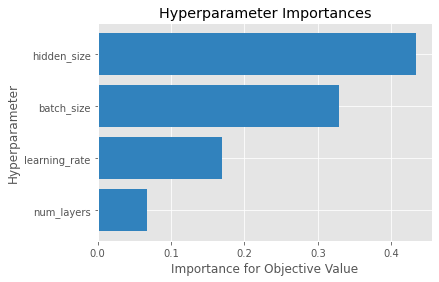

In [ ]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

Number of finished trials:  25
Best trial:
  Value:  25.80798653882269
  Params: 
    batch_size: 64
    learning_rate: 0.014949675790007754
    hidden_size: 16
    num_layers: 4


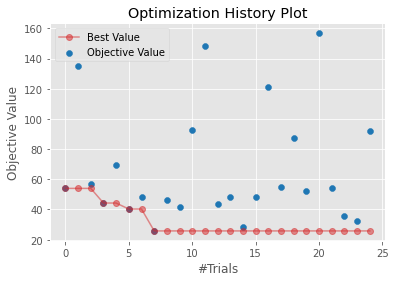

In [ ]:
print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# optuna.visualization.matplotlib.plot_param_importances(study)
# plt.show()


optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

## Plot Results

In [ ]:
torch.manual_seed(42)

log_interval = 10
num_classes = 1 # parameter에서 빼서 상수로 설정
num_epochs = 100 # parameter에서 빼서 상수로 설정

train_dl, val_dl, input_size = get_data_loader(x, y,  study.best_params['batch_size'])

model = LSTM(num_classes=num_classes,
                input_size=input_size, 
                hidden_size=study.best_params['hidden_size'], 
                num_layers=study.best_params['num_layers'])

if torch.cuda.is_available():
    model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr=study.best_params['learning_rate'])
criterion = torch.nn.MSELoss()
best_loss = train(log_interval, model, train_dl, val_dl, optimizer, criterion,  num_epochs)

print('best loss for the trial = ', best_loss)
predict_data = []

# 여기서 x는 (sample, lookback_length, 1)의 크기를 지님. 따라서, 제일 앞의 시점을 제거하려면, x[:, -1, :]이 되어야 함
x_pred = np.expand_dims(x_for_metric, 0)  # Inference에 사용할 lookback data를 x_pred로 지정. 앞으로 x_pred를 하나씩 옮겨 가면서 inference를 할 예정

# print('-----------------------y shape before loop = ', y.shape)
for j, i in enumerate(range(max_prediction_length)):

    # feed the last forecast back to the model as an input
    x_pred = np.append( x_pred[:, 1:, :], np.expand_dims(y_for_metric[j, :], (0,2)), axis=1)

    # print(f'After update data = {x_pred.shape}')
    xt_pred = torch.Tensor(x_pred)

    if torch.cuda.is_available():
        xt_pred = xt_pred.cuda()

    # generate the next forecast
    yt_pred = model(xt_pred)

    # print(f'model result yt_pred = {yt_pred.shape}')
    # tensor to array
    # x_pred = xt_pred.cpu().detach().numpy()
    y_pred = yt_pred.cpu().detach().numpy()

    # save the forecast
    predict_data.append(y_pred)


# transform the forecasts back to the original scale
predict_data = np.array(predict_data).reshape(-1, 1)
SMAPE = smape(y_for_metric, predict_data)
print(f' \nSMAPE : {SMAPE}')



 Epoch 0 	 Training Loss: 0.022796441253740342 	 Validation Loss: 0.18827576115727424 

Validation Loss Decreased(inf--->0.188276) 	 Saving The Model
Validation Loss Decreased(0.188276--->0.158746) 	 Saving The Model

 Epoch 10 	 Training Loss: 0.028290396140073427 	 Validation Loss: 0.37542605102062226 


 Epoch 20 	 Training Loss: 0.0112752937246114 	 Validation Loss: 0.1007685698568821 

Validation Loss Decreased(0.158746--->0.100769) 	 Saving The Model

 Epoch 30 	 Training Loss: 0.022714841258130038 	 Validation Loss: 0.3167910575866699 


 Epoch 40 	 Training Loss: 0.012788764212746172 	 Validation Loss: 0.1736393839120865 

Validation Loss Decreased(0.100769--->0.099226) 	 Saving The Model
Validation Loss Decreased(0.099226--->0.096381) 	 Saving The Model

 Epoch 50 	 Training Loss: 0.012196027746540494 	 Validation Loss: 0.15084692537784578 

Validation Loss Decreased(0.096381--->0.052638) 	 Saving The Model

 Epoch 60 	 Training Loss: 0.0068195171421393756 	 Validation Loss: 

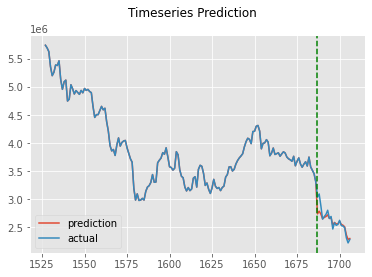

In [ ]:
predict = scaler.inverse_transform(predict_data)
pred_df = pd.concat([data_p[scale_cols], pd.DataFrame(predict, columns=['trade_price'])], axis=0).reset_index(drop=True)
pred_df = pred_df.rename(columns = {'trade_price':'pred_price'})
data_df = pd.concat([data, pred_df], axis=1)

plt.plot(data_df['pred_price'][len(data_df)-lookback_length*2:], label='prediction')
plt.plot(data_df['trade_price'][len(data_df)-lookback_length*2:], label='actual')
plt.suptitle('Timeseries Prediction')
plt.axvline(x = len(data_df) - len(predict_data), c = 'g', linestyle = '--')
plt.legend()
plt.show()

In [ ]:
data_df.loc[training_data_max:,:]

,date,trade_price,pred_price
1687,2022-05-09,3038000.0,2740677.75
1688,2022-05-10,3095000.0,2789122.50
1689,2022-05-11,2884000.0,2736573.25
1690,2022-05-12,2648000.0,2653853.75
1691,2022-05-13,2694000.0,2677715.00
1692,2022-05-14,2733000.0,2694038.00
1693,2022-05-15,2806000.0,2723763.75
1694,2022-05-16,2660000.0,2659486.75
1695,2022-05-17,2695000.0,2678051.00
1696,2022-05-18,2472000.0,2537104.00


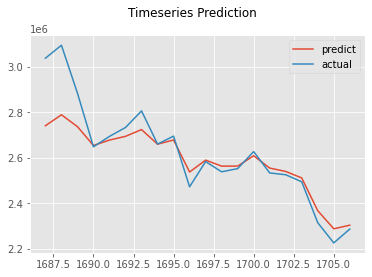

In [ ]:
plt.plot(data_df.loc[training_data_max:, 'pred_price'], label='predict')
plt.plot(data_df.loc[training_data_max:, 'trade_price'], label='actual')
plt.suptitle('Timeseries Prediction')
plt.legend()
plt.show();

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs/